In [40]:
import pandas as pd
import sklearn.preprocessing as skp
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

df = pd.read_csv('data/2_state_data.csv', index_col=0)

In [41]:
df = df.drop(columns=['pctDeathsBlack', 'pctDeathsWhite',
       'pctDeathsHispanic', 'pctDeathsNative', 'pctDeathsAsian',
       'pctDeathsOther'])

In [83]:
dfd.columns

Index(['Quantity', 'Acquisition Value', 'numStations', 'exp per station',
       'deaths', 'pctBodyCam', 'pctfleeing', 'pctMHSymptoms', 'pctPopWhite',
       'pctPopBlack', 'pctPopHisp', 'pctPopAsian', 'pctPopOther',
       'pctPopNative', 'Population', 'deaths_per_100k', 'AK', 'AL', 'AR', 'AZ',
       'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY',
       'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'SC', 'SD', 'TN',
       'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'],
      dtype='object')

In [43]:
dfd = pd.get_dummies(df['State'])

for series in dfd:
    dfd[series] = dfd[series].astype(float)
dfd = pd.concat([df.drop(['State'],axis=1),dfd],axis=1)


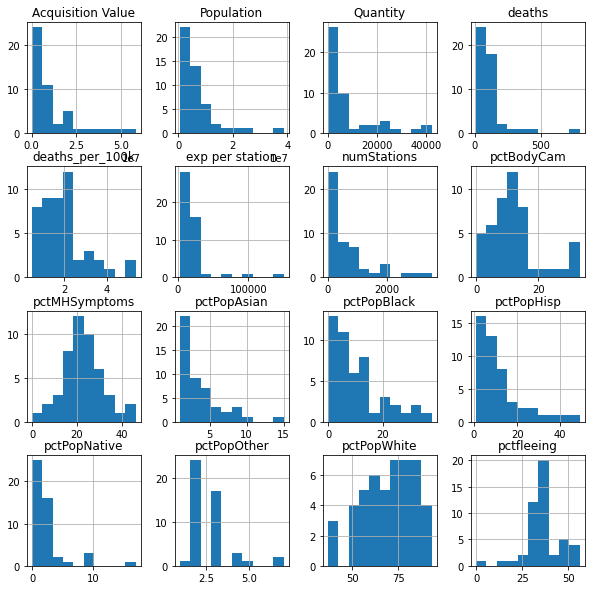

In [44]:
df.hist(figsize=(10,10))
plt.show()

In [45]:
from sklearn.preprocessing import StandardScaler
X = dfd.drop(columns=['deaths_per_100k','deaths']).values
y = dfd.deaths_per_100k.values

In [46]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [48]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# Modeling

## Model 1 - KNN

In [49]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score

In [50]:
knr = KNeighborsRegressor()
knr.fit(X_train, y_train)
y_pred = knr.predict(X_test)

In [51]:
r2_score(y_test,y_pred)

0.01459644821436068

In [52]:
param_grid = {'n_neighbors':np.arange(1,10),
             'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
knr_cv = GridSearchCV(knr, param_grid=param_grid, cv=5)
knr_cv.fit(X_train, y_train)
y_pred2 = knr_cv.predict(X_test)

knr_cv.best_params_

{'algorithm': 'auto', 'n_neighbors': 2}

In [53]:
knr2 = KNeighborsRegressor(n_neighbors=6)
knr2.fit(X_train, y_train)
y_pred3 = knr2.predict(X_test)

In [54]:
from sklearn.metrics import mean_squared_error, explained_variance_score
print("R2 Score: " + str(r2_score(y_test, y_pred3)))
print("MSE Score: " + str(mean_squared_error(y_test,y_pred3)))
print("Explained Variance Score: " + str(explained_variance_score(y_test,y_pred3)))

R2 Score: 0.11899497143024129
MSE Score: 0.5994833709810365
Explained Variance Score: 0.21652124615364243


Text(0, 0.5, 'Y_Pred Values')

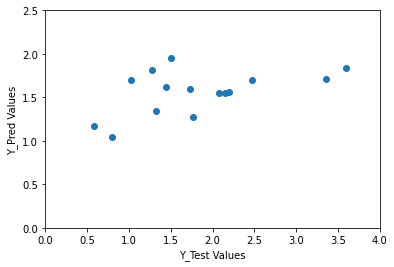

In [55]:
plt.scatter(x=y_test, y=y_pred3)
plt.xlim(0,4)
plt.ylim(0,2.5)
plt.xlabel('Y_Test Values')
plt.ylabel('Y_Pred Values')

## Model 2

In [56]:
import xgboost as xgb
from xgboost import XGBRegressor

xgbreg = XGBRegressor(random_state=42,silent=True)
xgbreg.fit(X_train,y_train)
y_pred4 = xgbreg.predict(X_test)


In [57]:
print("R2 Score: " + str(r2_score(y_test, y_pred4)))
print("MSE Score: " + str(mean_squared_error(y_test,y_pred4)))
print("Explained Variance Score: " + str(explained_variance_score(y_test,y_pred4)))

R2 Score: -0.3558681528956955
MSE Score: 0.9226058700519473
Explained Variance Score: -0.3555015879651482


In [58]:
param_grid = ({'n_estimators': np.arange(1,15),
               'max_depth': np.arange(1,15),
               'learning_rate':[0.1,0.3,0.5,0.7]})
xgbreg_cv = GridSearchCV(xgbreg, param_grid=param_grid, cv=5)
xgbreg_cv.fit(X_train, y_train)
y_pred5 = xgbreg_cv.predict(X_test)

In [59]:
xgbreg_cv.best_params_

{'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 8}

In [60]:
xgbreg2 = XGBRegressor(n_estimators=8, max_depth=2, learning_rate=0.5, booster='gbtree', random_state=42,silent=True)
xgbreg2.fit(X_train,y_train)
y_pred5 = xgbreg2.predict(X_test)

In [61]:
print("R2 Score: " + str(r2_score(y_test, y_pred5)))
print("MSE Score: " + str(mean_squared_error(y_test,y_pred5)))
print("Explained Variance Score: " + str(explained_variance_score(y_test,y_pred5)))

#odd, results are not as strong as before using gridsearch.

R2 Score: -0.5654518082780908
MSE Score: 1.0652179008086116
Explained Variance Score: -0.5453647768683996


In [87]:
features = pd.DataFrame(xgbreg.feature_importances_, xgbreg.get_booster().feature_names)
#features['value'] = dfd.columns[1:62]
#features[features[0]>0].sort_values(by=0, ascending=False)
features

,0,value
f0,0.020464,Quantity
f1,0.010875,Acquisition Value
f2,0.016176,numStations
f3,0.013814,exp per station
f4,0.008624,deaths
...,...,...
f57,0.000000,UT
f58,0.000000,VA
f59,0.000000,VT
f60,0.000000,WA


In [75]:
pd.DataFrame(dfd.columns)

,0
0,Quantity
1,Acquisition Value
2,numStations
3,exp per station
4,deaths
...,...
59,VT
60,WA
61,WI
62,WV


Text(0, 0.5, 'Y_Pred Values')

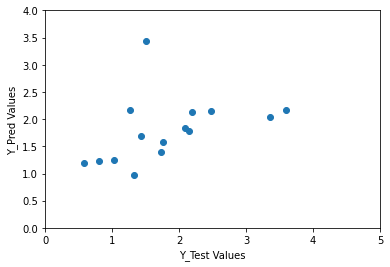

In [23]:
plt.scatter(x=y_test, y=y_pred4)
plt.xlim(0,5)
plt.ylim(0,4)
plt.xlabel('Y_Test Values')
plt.ylabel('Y_Pred Values')

## Model 2.5

In [24]:
## dropping alaska as an outlier
X2 = dfd.drop(columns=['deaths_per_100k','deaths','AK']).values
y2 = dfd.deaths_per_100k.values
scaler = StandardScaler()
X2 = scaler.fit_transform(X2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=123)
y2_train = y2_train.reshape(-1,1)
y2_test = y2_test.reshape(-1,1)

In [26]:
xgbreg2 = XGBRegressor(random_state=42,silent=True)
xgbreg2.fit(X2_train,y2_train)
y2_pred = xgbreg2.predict(X2_test)

In [27]:
print("R2 Score: " + str(r2_score(y2_test, y2_pred)))
print("MSE Score: " + str(mean_squared_error(y2_test,y2_pred)))
print("Explained Variance Score: " + str(explained_variance_score(y2_test,y2_pred)))

R2 Score: 0.06434180380040333
MSE Score: 0.6366723359733432
Explained Variance Score: 0.06490052722056083


In [28]:
features2 = pd.DataFrame(xgbreg2.feature_importances_, index=dfd.columns[1:68])
features2[features2[0]>0].sort_values(by=0, ascending=False)

,0
pctPopNative,0.530638
pctPopAsian,0.152446
exp per station,0.053127
pctDeathsNative,0.042837
pctDeathsBlack,0.033530
pctDeathsOther,0.033360
pctDeathsWhite,0.031251
Population,0.028683
pctPopBlack,0.021564
Acquisition Value,0.019192


In [ ]:
## Asian Population still remains highly weighted even after dropping Alaska

## Model 3

In [86]:
from sklearn.linear_model import Lasso

In [92]:
lasso = Lasso(random_state=42)
lasso.fit(X_train,y_train)
y_pred6 = lasso.predict(X_test)

In [93]:
print("R2 Score: " + str(r2_score(y_test, y_pred6)))
print("MSE Score: " + str(mean_squared_error(y_test,y_pred6)))
print("Explained Variance Score: " + str(explained_variance_score(y_test,y_pred6)))
lasso.get_params

R2 Score: -0.057613975188765654
MSE Score: 0.7196576301864016
Explained Variance Score: 0.003752538363008262


<bound method BaseEstimator.get_params of Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)>

In [41]:
param_grid = {'fit_intercept':[True,False],
              'normalize':[True,False],
              'max_iter': [500, 1000, 1500]
             }
lasso_cv = GridSearchCV(lasso, param_grid=param_grid, cv=5)
lasso_cv.fit(X_train, y_train)
y_pred3 = lasso_cv.predict(X_test)

lasso_cv.best_params_

{'fit_intercept': True, 'max_iter': 500, 'normalize': False}

In [49]:
lasso2 = Lasso(random_state=42, max_iter=1500)
lasso2.fit(X_train,y_train)
y_pred7 = lasso2.predict(X_test)

In [54]:
print("R2 Score: " + str(r2_score(y_test, y_pred7)))
print("MSE Score: " + str(mean_squared_error(y_test,y_pred7)))
print("Explained Variance Score: " + str(explained_variance_score(y_test,y_pred7)))

R2 Score: -0.057613975188765654
MSE Score: 0.7196576301864016
Explained Variance Score: 0.003752538363008262


In [51]:
features3 = pd.DataFrame(lasso.coef_, index=dfd.columns[1:69])
features3[features3[0]>0].sort_values(by=0, ascending=False)

,0
pctPopNative,0.050385


## Model 4

In [79]:
from sklearn.linear_model import ElasticNetCV

In [85]:
enet_cv = ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1], cv=5)
enet_cv.fit(X_train, y_train)
y_pred8 = enet_cv.predict(X_test)

/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [77]:
print("R2 Score: " + str(r2_score(y_test, y_pred8)))
print("MSE Score: " + str(mean_squared_error(y_test,y_pred8)))
print("Explained Variance Score: " + str(explained_variance_score(y_test,y_pred8)))

R2 Score: -0.16305982867663804
MSE Score: 0.7914086800158259
Explained Variance Score: -0.13123814614299656


# Model Results

| Model | Explained Variance| Mean Squared Error| R2 Score | Features Dropped | 
| --- | --- | --- | --- | --- |
| Model 1. (KNeighbors Regression) | 0.14 | 0.62 | 0.089 | 'deaths' |
| Model 2. (XGB) | 0.065 | 0.64 | 0.064 | 'deaths' |
| Model 2.5 (XGB) | 0.065 | 0.64 | 0.065 | 'deaths', 'AK' |
| Model 3 (Lasso) | 0.003 | 0.72| -0.058| 'deaths' | 
| Model 3 (Elastic Nt) | -0.131 | 0.79| -0.16| 'deaths' | 



Model Selection: Model 2